In [2]:
import time
from torch.utils.tensorboard import SummaryWriter
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader
import torchvision.models as models
import torch.nn as nn
import torch

In [ ]:
print("是否使用GPU训练：{}".format(torch.cuda.is_available()))    #打印是否采用gpu训练
if torch.cuda.is_available:
    print("GPU名称为：{}".format(torch.cuda.get_device_name()))  #打印相应的gpu信息
#数据增强太多也可能造成训练出不好的结果，而且耗时长，宜增强两三倍即可。
normalize=transforms.Normalize(mean=[.5,.5,.5],std=[.5,.5,.5])  #规范化
transform=transforms.Compose([                                  #数据处理
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    normalize
])
dataset_train=ImageFolder('Baidu',transform=transform)     #训练数据集
# print(dataset_tran[0])
dataset_valid=ImageFolder('验证',transform=transform)     #验证或测试数据集
# print(dataset_train.classer)#返回类别
print(dataset_train.class_to_idx)                               #返回类别及其索引
# print(dataset_train.imgs)#返回图片路径
print(dataset_valid.class_to_idx)
train_data_size=len(dataset_train)                              #放回数据集长度
test_data_size=len(dataset_valid)
print("训练数据集的长度为：{}".format(train_data_size))
print("测试数据集的长度为：{}".format(test_data_size))
#torch自带的标准数据集加载函数
dataloader_train=DataLoader(dataset_train,batch_size=4,shuffle=True,num_workers=0,drop_last=True)
dataloader_test=DataLoader(dataset_valid,batch_size=4,shuffle=True,num_workers=0,drop_last=True)

#2.模型加载
model_ft=models.resnet18(pretrained=True)#使用迁移学习，加载预训练权重
# print(model_ft)

in_features=model_ft.fc.in_features
model_ft.fc=nn.Sequential(nn.Linear(in_features,25),
                          nn.Linear(25,5))#将最后的全连接改为（36，6），使输出为六个小数，对应六种植物的置信度
#冻结卷积层函数
# for i,para in enumerate(model_ft.parameters()):
#     if i<18:
#         para.requires_grad=False

# print(model_ft)


# model_ft.half()#可改为半精度，加快训练速度，在这里不适用

model_ft=model_ft.cuda()#将模型迁移到gpu
#3.优化器
loss_fn=nn.CrossEntropyLoss()

loss_fn=loss_fn.cuda()  #将loss迁移到gpu
learn_rate=0.01         #设置学习率
optimizer=torch.optim.SGD(model_ft.parameters(),lr=learn_rate,momentum=0.01)#可调超参数

total_train_step=0
total_test_step=0
epoch=20                #迭代次数
writer=SummaryWriter("logs_train_yaopian")
best_acc=-1
ss_time=time.time()

for i in range(epoch):
    start_time = time.time()
    print("--------第{}轮训练开始---------".format(i+1))
    model_ft.train()
    for data in dataloader_train:
        imgs,targets=data
        # if torch.cuda.is_available():
        # imgs.float()
        # imgs=imgs.float()#为上述改为半精度操作，在这里不适用
        imgs=imgs.cuda()
        targets=targets.cuda()
        # imgs=imgs.half()
        outputs=model_ft(imgs)
        loss=loss_fn(outputs,targets)

        optimizer.zero_grad()   #梯度归零
        loss.backward()         #反向传播计算梯度
        optimizer.step()        #梯度优化

        total_train_step=total_train_step+1
        if total_train_step%100==0:#一轮时间过长可以考虑加一个
            end_time=time.time()
            print("使用GPU训练100次的时间为：{}".format(end_time-start_time))
            print("训练次数：{},loss:{}".format(total_train_step,loss.item()))
            # writer.add_scalar("valid_loss",loss.item(),total_train_step)
    model_ft.eval()
    total_test_loss=0
    total_accuracy=0
    with torch.no_grad():       #验证数据集时禁止反向传播优化权重
        for data in dataloader_test:
            imgs,targets=data
            # if torch.cuda.is_available():
            # imgs.float()
            # imgs=imgs.float()
            imgs = imgs.cuda()
            targets = targets.cuda()
            # imgs=imgs.half()
            outputs=model_ft(imgs)
            loss=loss_fn(outputs,targets)
            total_test_loss=total_test_loss+loss.item()
            accuracy=(outputs.argmax(1)==targets).sum()
            total_accuracy=total_accuracy+accuracy
        print("整体测试集上的loss：{}(越小越好,与上面的loss无关此为测试集的总loss)".format(total_test_loss))
        print("整体测试集上的正确率：{}(越大越好)".format(total_accuracy / len(dataset_valid)))

        writer.add_scalar("valid_loss",(total_accuracy/len(dataset_valid)),(i+1))#选择性使用哪一个
        total_test_step = total_test_step + 1
        if total_accuracy > best_acc:   #保存迭代次数中最好的模型
            print("已修改模型")
            best_acc = total_accuracy
            torch.save(model_ft, "best_model_yaopian.pth")
ee_time=time.time()
zong_time=ee_time-ss_time
print("训练总共用时:{}h:{}m:{}s".format(int(zong_time//3600),int((zong_time%3600)//60),int(zong_time%60))) #打印训练总耗时
writer.close()

In [24]:
def show_pics(pics):
    print(pics[0].shape)
    plt.figure(figsize=(3 * len(pics), 3), dpi=80)
    for i in range(len(pics)):
        pics[i] = (pics[i] + 1) / 2 #(pics[i][0].transpose((1,2,0)) + 1) / 2
        plt.subplot(1, len(pics), i + 1)
        plt.imshow(pics[i],cmap='gray')
        plt.xticks([])
        plt.yticks([])

_________________________________________________________________
(810, 1080, 3)
(51, 68)


<Figure size 640x480 with 0 Axes>

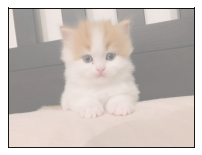

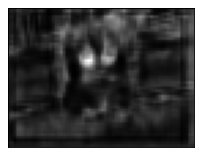

In [40]:
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np
model_ft=torch.load("best_model_yaopian.pth",map_location=torch.device("cuda")) #选择训练后得到的模型文件
#print(model_ft)
print("_________________________________________________________________")
model_ft.eval()
with torch.no_grad():
    conv1 =model_ft.conv1
    layer1 = model_ft.layer1
    layer2 = model_ft.layer2
    layer3 = model_ft.layer3
    layer4 = model_ft.layer4
    #layer1.conv2 = nn.Conv2d(64,3,kernel_size=1,padding = 0,bias = False).to('cuda') 
    #layer1.conv2.weight.data=1e-2*torch.rand(3,64,1,1).to('cuda')
    #print(layer1.conv2.weight.data[0][0])
#     layer1.bn1 = nn.Sequential()
    # layer1[0].conv2 = nn.Conv2d(64,3,kernel_size=3,padding = 1,bias = False).to('cuda') 
    # layer1[0].bn2 = nn.BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True).to('cuda')
    # layer1[1].conv2 = nn.Conv2d(64,3,kernel_size=3,padding = 1,bias = False).to('cuda') 
    # layer1[1].bn2 = nn.BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True).to('cuda')
    #print(layer1)
    img = Image.open("test图片/10cat.jpg")
    img = np.array(img)
    #print(img.shape)
    #print(np.array(img))
    plt.figure()
    show_pics([img/255])
    
    transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=[.5,.5,.5],std=[.5,.5,.5])])
    img = transform(img).to('cuda')
    #print(img)
    img = img.unsqueeze(dim=0)
    out = conv1(img)
    #print(out.shape)
    out = layer1(out)
    out = layer2(out)
    out = layer3(out)
    out = layer4(out)
    out = out.squeeze()
    out = out.cpu().numpy()
    out2 = out[0]/out.shape[0]
    for i in range(out.shape[0]):
        out2 += (out[i]/out.shape[0])
        #print(out.shape)
        #out = out.permute(1,2,0)
        #out2 = np.int16(255/(1+np.exp(-out2)))
        #print(out)
    show_pics([out2])

In [4]:
import os
import torch
import torchvision
from PIL import Image
from torch import nn
i=0 #识别图片计数
root_path="test图片"         #待测试文件夹
names=os.listdir(root_path)
model=torch.load("best_model_yaopian.pth",map_location=torch.device("cpu")) #选择训练后得到的模型文件
model.eval()
for name in names:
    print(name)
    i=i+1
    data_class=['熊','鸟','猫','狗','蛇']   #按文件索引顺序排列
    image_path=os.path.join(root_path,name)             
    image=Image.open(image_path)
    print(image)
    transforms=torchvision.transforms.Compose([torchvision.transforms.Resize((64,64)),
                                              torchvision.transforms.ToTensor()])
    image=transforms(image)
    print(image.shape)

#     model_ft=torchvision.models.resnet18()      #需要使用训练时的相同模型
#     # print(model_ft)
#     in_features=model_ft.fc.in_features
#     model_ft.fc=nn.Sequential(nn.Linear(in_features,36),
#                               nn.Linear(36,6))     #此处也要与训练模型一致
    # print(model)
    image=torch.reshape(image,(1,3,64,64))      #修改待预测图片尺寸，需要与训练时一致
    with torch.no_grad():
        output=model(image)
    print(output)               #输出预测结果
    # print(int(output.argmax(1)))
    print("第{}张图片预测为：{}".format(i,data_class[int(output.argmax(1))]))   #对结果进行处理，使直接显示出预测的植物种类


10cat.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x810 at 0x23E6AF2A550>
torch.Size([3, 64, 64])
tensor([[ 2.8062, -3.9377,  5.0229, -1.3567, -0.3708]])
第1张图片预测为：猫
10snake.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=576x358 at 0x23E6AF2AD90>
torch.Size([3, 64, 64])
tensor([[-0.6216,  1.2811, -0.4969, -0.8088,  2.2090]])
第2张图片预测为：蛇
11cat.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1350 at 0x23E6AF2A940>
torch.Size([3, 64, 64])
tensor([[-1.0383, -1.2655,  3.6799, -1.0082, -1.1563]])
第3张图片预测为：猫
11snake.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x480 at 0x23E6AF2A880>
torch.Size([3, 64, 64])
tensor([[-2.3568,  0.3578,  1.1224, -0.8471,  1.6655]])
第4张图片预测为：蛇
12cat.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1080 at 0x23E6AF2AA90>
torch.Size([3, 64, 64])
tensor([[-3.0957,  1.1155,  3.7637, -2.1442,  1.2461]])
第5张图片预测为：猫
12snake.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x607 at 0x